# Comparative analysis of structural, learned, and hybrid feature representations for graph clustering

##### Final "Learning From Networks" course project
##### Authors: Chiara Frizzarin, Leonardo Gusson, Luca Rao
##### Date: 16/01/2026

---
## Notebook configuration

Use the following configuration cell to control the notebook's execution behavior.

By default, the `RECOMPUTE_*` flags are set to `False` to load pre-calculated results included in the repository at
`../data/processed/`.
The `DEVICE` parameter determines whether computations run on the CPU or GPU for functions that support acceleration.

In [1]:
import os
from pathlib import Path

DATA_DIR = Path("../data")
PROCESSED_DATA_DIR = DATA_DIR / "processed"
RESULTS_DIR = DATA_DIR / "results"

INPUT_DATA_PATH = DATA_DIR / "amazon-meta.txt"
PICKLE_PATH = PROCESSED_DATA_DIR / "amazon_graph.pickle"
REVIEWSCORE_PATH = PROCESSED_DATA_DIR / "review_scores.csv"
HARMSCORE_PATH = PROCESSED_DATA_DIR / "harmonic_scores.csv"
BETSCORE_PATH = PROCESSED_DATA_DIR / "bet_scores.csv"
CLUSSCORE_PATH = PROCESSED_DATA_DIR / "clus_scores.csv"
PRSCORE_PATH = PROCESSED_DATA_DIR / "pagerank_scores.csv"
EMBEDDINGS_PATH = PROCESSED_DATA_DIR / "embeddings.csv"
RED_EMBEDDINGS_PATH = PROCESSED_DATA_DIR / "embeddings_reduced.csv"
STRUCTURAL_METRICS_PATH = PROCESSED_DATA_DIR / "structural_metrics.csv"
RESULTS_FILE = RESULTS_DIR / "clustering_results.csv"

class Config:
    DEVICE = "cuda"     # options: "cpu", "cuda"
    USE_HANDMADE_IMPLEMENTATIONS = True

    RECOMPUTE_DATA_PROCESSING = False
    RECOMPUTE_HARMONIC_CENTRALITY = False       # has 'cpu' and 'cuda' versions, both hand-made implementations
    RECOMPUTE_BETWEENNESS_CENTRALITY = False    # has nx library and hand-made versions, both run on cpu
    RECOMPUTE_CLUSTERING_COEFFICIENT = False    # has nx library and hand-made versions, both run on cpu
    RECOMPUTE_PAGERANK = False      # has cpu, cuda, apple silicon versions, all hand-made implementations
                                    # the execution platform is automatically chosen, regardless of the DEVICE flag

    RECOMPUTE_EMBEDDINGS = False                # has 'cpu' and 'cuda' versions, both hand-made implementations
    REAPPLY_UMAP = False

    CLUSTERING_ALGORITHM = 'kmeans'    # options: 'kmeans', 'gmm'

config = Config()

---
## Common imports

In [2]:
import sys
import time
import numpy as np
import pandas as pd
import re

import pickle
import networkx as nx

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import normalized_mutual_info_score

import seaborn as sns 
import matplotlib.pyplot as plt

# other dependencies needed when enabling "recompute" flags

# import cupy as cp
# from node2vec import Node2Vec
# import torch
# from torch_geometric.nn import Node2Vec as torch_Node2Vec
# from torch_geometric.utils import from_networkx
# import umap
# import mlx.core

sys.path.append(os.path.abspath('..'))

---
## Data processing

In [3]:
from src import load_or_compute, create_graph_pickle, compute_review_scores

if config.RECOMPUTE_DATA_PROCESSING:
    start_time = time.time()
    create_graph_pickle(INPUT_DATA_PATH, PICKLE_PATH)
    elapsed = time.time() - start_time

df_review = load_or_compute(
    REVIEWSCORE_PATH,
    compute_review_scores,
    config.RECOMPUTE_DATA_PROCESSING,
    dataset_path=INPUT_DATA_PATH,
)

# Load the input graph from the pickle file
with open(PICKLE_PATH, "rb") as f:
    G = pickle.load(f)

print("Graph loaded")

File found.
Graph loaded


---
---
# A. Structural Features + SalesRank + Review Score

## Phase 1 : Building Feature Vectors

#### Harmonic centrality

In [4]:
from src import load_or_compute
from src.features import get_harmonic_centrality


start_time = time.time()

df_harmonic_scores = load_or_compute(
    HARMSCORE_PATH,
    get_harmonic_centrality,
    config.RECOMPUTE_HARMONIC_CENTRALITY,
    G=G,
    p=10,
    version=config.DEVICE
)
display(df_harmonic_scores.head(5))

elapsed = time.time() - start_time
print(
    f"Harmonic centrality "
    f"{'recomputed' if config.RECOMPUTE_HARMONIC_CENTRALITY else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.


,HarmonicCentrality
ASIN,
0827229534,10890.978000
0738700797,9056.977000
0842328327,2.840921
1577943082,5.111011
0486220125,0.000000


Harmonic centrality loaded in 0.16 seconds.


#### Betweenness Centrality

In [5]:
from src import load_or_compute
from src.features import get_approx_betweenness


start_time = time.time()

df_bet = load_or_compute(
    BETSCORE_PATH,
    get_approx_betweenness,
    config.RECOMPUTE_BETWEENNESS_CENTRALITY,
    G=G,
    k=1000,
    use_networkx=(not config.USE_HANDMADE_IMPLEMENTATIONS)
)
display(df_bet.head(5))

elapsed = time.time() - start_time
print(
    f"Betweenness centrality "
    f"{'recomputed' if config.RECOMPUTE_BETWEENNESS_CENTRALITY else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.


,bet
ASIN,
0827229534,0.0
0738700797,0.0
0842328327,0.0
1577943082,0.0
0486220125,0.0


Betweenness centrality loaded in 0.14 seconds.


#### PageRank

In [6]:
from src import load_or_compute
from src.features import get_pagerank


start_time = time.time()

df_pagerank = load_or_compute(
    PRSCORE_PATH,
    get_pagerank,
    config.RECOMPUTE_PAGERANK,
    G=G,
    force_cpu=False
)
display(df_pagerank.head(5))

elapsed = time.time() - start_time
print(
    f"Page Rank "
    f"{'recomputed' if config.RECOMPUTE_PAGERANK else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.


,pagerank
ASIN,
0827229534,5.332977e-06
0738700797,9.438284e-06
0842328327,6.925232e-07
1577943082,1.400741e-06
0486220125,4.671820e-07


Page Rank loaded in 0.17 seconds.


#### Clustering Coefficient

In [7]:
from src import load_or_compute
from src.features import get_clustering_coefficient

start_time = time.time()

df_clus = load_or_compute(
    CLUSSCORE_PATH,
    get_clustering_coefficient,
    config.RECOMPUTE_CLUSTERING_COEFFICIENT,
    G=G,
    M=G.number_of_edges(),
    use_networkx=(not config.USE_HANDMADE_IMPLEMENTATIONS)
)
display(df_clus.head(5))

elapsed = time.time() - start_time
print(
    f"Clustering coefficient "
    f"{'recomputed' if config.RECOMPUTE_CLUSTERING_COEFFICIENT else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

Computing
Saving to ..\data\processed\clus_scores.csv...


,clus
ASIN,
0827229534,0.174242
0738700797,0.230769
0842328327,0.366667
1577943082,0.450000
0486220125,0.250000


Clustering coefficient recomputed in 5.92 seconds.


### => Structural Features Vector

In [8]:
struct_df = [df_pagerank,df_clus,df_bet,df_harmonic_scores]
for df in struct_df:
    if 'ASIN' in df.columns:
        df.set_index('ASIN', inplace=True)
    # If the index is already ASIN but not named, rename it for clarity
    df.index.name = 'ASIN'
df_final = pd.concat(struct_df,axis=1, join='outer')
df_final = df_final.fillna(0)

display(df_final)

,pagerank,clus,bet,HarmonicCentrality
ASIN,,,,
0827229534,5.332977e-06,0.174242,0.0,10890.978000
0738700797,9.438284e-06,0.230769,0.0,9056.977000
0842328327,6.925232e-07,0.366667,0.0,2.840921
1577943082,1.400741e-06,0.450000,0.0,5.111011
0486220125,4.671820e-07,0.250000,0.0,0.000000
...,...,...,...,...
B00008MNUJ,4.671820e-07,0.333333,0.0,0.000000
0060537612,4.671820e-07,0.150000,0.0,0.000000
B00006JBIX,4.671820e-07,0.000000,0.0,0.000000


#### SalesRank Score

In [9]:
salesrank_dict = nx.get_node_attributes(G, 'salesrank')

# Convert to DataFrame
df_salesrank = pd.DataFrame.from_dict(salesrank_dict, orient='index', columns=['salesrank'])
df_salesrank.index.name = 'ASIN'
df_final = df_final.join(df_salesrank) # Join to df_final

# Check the result
display(df_final.head())

,pagerank,clus,bet,HarmonicCentrality,salesrank
ASIN,,,,,
0827229534,5.332977e-06,0.174242,0.0,10890.978000,396585.0
0738700797,9.438284e-06,0.230769,0.0,9056.977000,168596.0
0842328327,6.925232e-07,0.366667,0.0,2.840921,631289.0
1577943082,1.400741e-06,0.450000,0.0,5.111011,455160.0
0486220125,4.671820e-07,0.250000,0.0,0.000000,188784.0


#### Review Scores
In this case we need to use the merge intead of join because the score reviews are computed on the whole dataset instead of the LCC and so we need to ensure that only scores with the same ASIN are added

In [10]:
display(df_review.head())
df_final = pd.merge(df_final, df_review[['rw_score']], on='ASIN', how='left')
df_final = df_final.fillna(0)

,rw_score,num_reviews
ASIN,,
0827229534,5.000000,2
0738700797,4.136364,12
0486287785,5.000000,1
0842328327,4.000000,1
1577943082,2.500000,0


### => Structural Features + sr + rw Vector

In [11]:
display(df_final.head())
df_final.to_csv(STRUCTURAL_METRICS_PATH)

,pagerank,clus,bet,HarmonicCentrality,salesrank,rw_score
ASIN,,,,,,
0827229534,5.332977e-06,0.174242,0.0,10890.978000,396585.0,5.000000
0738700797,9.438284e-06,0.230769,0.0,9056.977000,168596.0,4.136364
0842328327,6.925232e-07,0.366667,0.0,2.840921,631289.0,4.000000
1577943082,1.400741e-06,0.450000,0.0,5.111011,455160.0,2.500000
0486220125,4.671820e-07,0.250000,0.0,0.000000,188784.0,4.550296


### Normalization

1. Salesrank in logarithmic scale

In [12]:
df_final['salesrank_log'] = np.log1p(df_final['salesrank'])
features = list(df_final.columns)
features.remove('salesrank')

X=df_final[features]
X=X.fillna(0)
display(X.head())

,pagerank,clus,bet,HarmonicCentrality,rw_score,salesrank_log
ASIN,,,,,,
0827229534,5.332977e-06,0.174242,0.0,10890.978000,5.000000,12.890648
0738700797,9.438284e-06,0.230769,0.0,9056.977000,4.136364,12.035267
0842328327,6.925232e-07,0.366667,0.0,2.840921,4.000000,13.355521
1577943082,1.400741e-06,0.450000,0.0,5.111011,2.500000,13.028406
0486220125,4.671820e-07,0.250000,0.0,0.000000,4.550296,12.148364


2. Z-score: setting mean around 0 and variance around 1 for every element of the vector

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=features)

print("Mean of scaled structural features:")
print(df_scaled.mean())
print("Std of scaled structural features:")
print(df_scaled.std())

Mean of scaled structural features:
pagerank              1.358091e-18
clus                 -1.588967e-16
bet                  -1.358091e-18
HarmonicCentrality   -2.498888e-16
rw_score              4.390030e-16
salesrank_log         2.048002e-15
dtype: float64
Std of scaled structural features:
pagerank              1.000001
clus                  1.000001
bet                   1.000001
HarmonicCentrality    1.000001
rw_score              1.000001
salesrank_log         1.000001
dtype: float64


## Phase 2 : Clustering

We initialize only here the clustering method

In [14]:
if config.CLUSTERING_ALGORITHM == 'kmeans':
    model = KMeans(n_clusters=4, random_state=42, n_init=10)
    
elif config.CLUSTERING_ALGORITHM == 'gmm':
    model = GaussianMixture(n_components=4, random_state=42, n_init=1)
    
else:
    raise ValueError(f"unknown alg: {config.CLUSTERING_ALGORITHM}, check flag at the beginning of the notebook")

In [15]:
clusters = model.fit_predict(X_scaled)

df_final['cluster_struct'] = clusters

# Print nodes for every group
print(df_final['cluster_struct'].value_counts())

cluster_struct
2    177241
0     76724
1     76389
3      4489
Name: count, dtype: int64


In [16]:
groups_dict = nx.get_node_attributes(G, 'group')

# Convert to DataFrame
df_groups = pd.DataFrame.from_dict(groups_dict, orient='index', columns=['group'])
df_groups.index.name = 'ASIN'

# Remove 'group' from node attributes if it exists to avoid conflict
if 'group' in df_final.columns:
    df_final = df_final.drop(columns=['group'])

df_final = df_final.join(df_groups)

In [17]:
crosstab = pd.crosstab(df_final['cluster_struct'], df_final['group'])

print(crosstab)

group             Book   DVD  Music  Video
cluster_struct                            
0                56951  4836  13541   1396
1                66417  2747   5172   2053
2               121975  7800  35608  11858
3                 3573   360    503     53


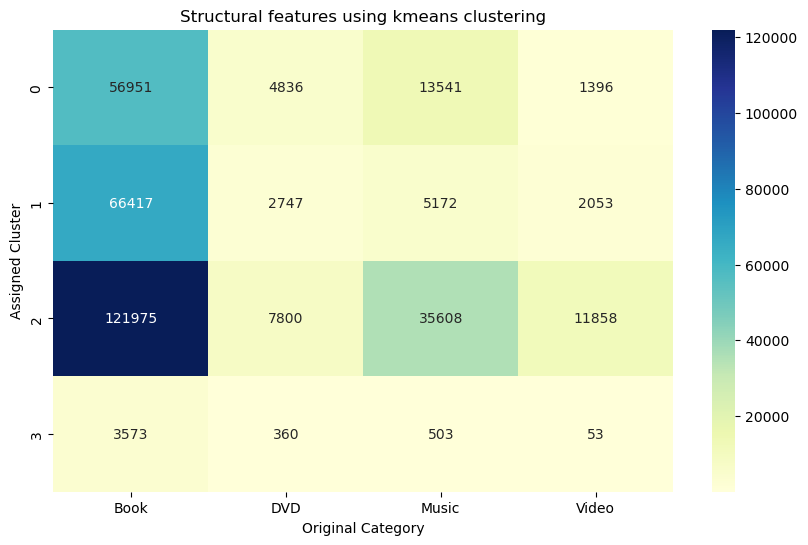

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.title('Structural features using '+ config.CLUSTERING_ALGORITHM + ' clustering' )
plt.xlabel('Original Category')
plt.ylabel('Assigned Cluster')
plt.show()

## Phase 3 : Calculating NMI

In [19]:
from src.utils import log_clustering_results

df_eval_struct = df_final.dropna(subset=['group', 'cluster_struct'])

nmi_struct = normalized_mutual_info_score(df_eval_struct['group'], df_eval_struct['cluster_struct'])

print(f"Normalized Mutual Information (NMI): {nmi_struct:.4f}")

log_clustering_results("Structural", nmi_struct, overwrite=True)

Normalized Mutual Information (NMI): 0.0226
Clustering results for Structural saved correctly.


---
# B. Embeddings Features

## Phase 1 : Building Feature Vectors

In [20]:
from src.features import get_node2vec_embeddings, apply_umap

start_time = time.time()

df_embeddings = load_or_compute(
    EMBEDDINGS_PATH,
    get_node2vec_embeddings,
    config.RECOMPUTE_EMBEDDINGS,
    G=G,
    p=1,
    q=2,
    version=config.DEVICE,
)

df_embeddings = load_or_compute(
    RED_EMBEDDINGS_PATH,
    apply_umap,
    config.REAPPLY_UMAP,
    df_embeddings=df_embeddings
    #umap_metric = 'cosine', 'euclidean'
)

elapsed = time.time() - start_time
print(
    f"Embeddings "
    f"{'recomputed' if config.RECOMPUTE_EMBEDDINGS else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.
File found.
Embeddings loaded in 4.01 seconds.


### Normalization

In [21]:
X = df_embeddings.values
X_norm = normalize(X)

print("Mean of scaled structural features:")
print(df_embeddings.mean())
print("Std of scaled structural features:")
print(df_embeddings.std())

Mean of scaled structural features:
umap_0    -0.058634
umap_1    10.111474
umap_2    -0.659167
umap_3    10.379951
umap_4    -0.637803
umap_5     9.764736
umap_6    -0.808103
umap_7     9.982720
umap_8     0.033969
umap_9    10.453093
dtype: float64
Std of scaled structural features:
umap_0    0.799976
umap_1    0.819057
umap_2    0.773691
umap_3    0.607518
umap_4    0.732214
umap_5    0.811310
umap_6    0.680833
umap_7    0.711583
umap_8    0.740224
umap_9    0.730452
dtype: float64


## Phase 2 : Clustering

In [22]:
clusters = model.fit_predict(X_norm)
df_emb_with_cluster = df_embeddings.copy()
df_emb_with_cluster['cluster_emb'] = clusters

# Print nodes for every group
print(df_emb_with_cluster['cluster_emb'].value_counts())

cluster_emb
1    179377
2     62416
0     47362
3     45688
Name: count, dtype: int64


In [23]:
if 'cluster_emb' not in df_final.columns:
    df_final['cluster_emb'] = np.nan

df_final.update(df_emb_with_cluster[['cluster_emb']])

df_final.head()

,pagerank,clus,bet,HarmonicCentrality,salesrank,rw_score,salesrank_log,cluster_struct,group,cluster_emb
ASIN,,,,,,,,,,
0827229534,5.332977e-06,0.174242,0.0,10890.978000,396585.0,5.000000,12.890648,0,Book,1.0
0738700797,9.438284e-06,0.230769,0.0,9056.977000,168596.0,4.136364,12.035267,0,Book,3.0
0842328327,6.925232e-07,0.366667,0.0,2.840921,631289.0,4.000000,13.355521,2,Book,1.0
1577943082,1.400741e-06,0.450000,0.0,5.111011,455160.0,2.500000,13.028406,1,Book,1.0
0486220125,4.671820e-07,0.250000,0.0,0.000000,188784.0,4.550296,12.148364,2,Book,3.0


In [24]:
crosstab = pd.crosstab(df_final['cluster_emb'], df_final['group'])
print(crosstab)

group          Book   DVD  Music  Video
cluster_emb                            
0.0            7827  8800  25326   5409
1.0          136339  6338  27754   8946
2.0           60866   297    646    607
3.0           43884   308   1098    398


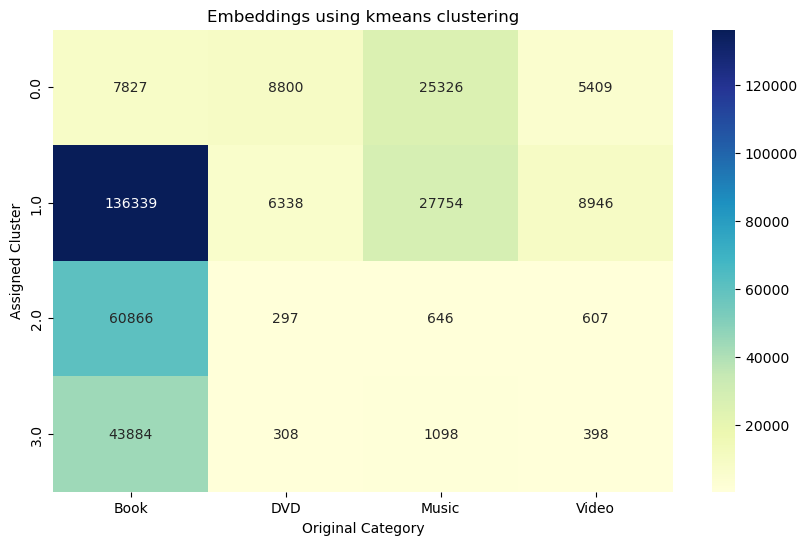

In [25]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.title('Embeddings using '+ config.CLUSTERING_ALGORITHM + ' clustering' )
plt.xlabel('Original Category')
plt.ylabel('Assigned Cluster')
plt.show()

## Phase 3 : Calculating NMI

In [26]:
df_eval_emb = df_final.dropna(subset=['group', 'cluster_emb'])

nmi_emb = normalized_mutual_info_score(df_eval_emb['group'], df_eval_emb['cluster_emb'])

print(f"Normalized Mutual Information (NMI): {nmi_emb:.4f}")

log_clustering_results("Learned", nmi_emb, overwrite=False)

Normalized Mutual Information (NMI): 0.1693
Clustering results for Learned saved correctly.


---
## C. Hybrid Features

## Phase 1 : Building Feature Vectors

In [27]:
# Get structural features

# Use again salesrank in logarithmic scale
df_salesrank['salesrank_log'] = np.log1p(df_salesrank['salesrank'])

data_frames = [df_pagerank,df_clus,df_bet,df_harmonic_scores,df_salesrank[['salesrank_log']]]

df_struct = pd.concat(data_frames,axis=1)
df_struct = pd.merge(df_struct, df_review[['rw_score']], on='ASIN', how='left')
df_struct = df_struct.fillna(0)
df_struct.head(10)


,pagerank,clus,bet,HarmonicCentrality,salesrank_log,rw_score
ASIN,,,,,,
0827229534,5.332977e-06,0.174242,0.0,10890.978000,12.890648,5.000000
0738700797,9.438284e-06,0.230769,0.0,9056.977000,12.035267,4.136364
0842328327,6.925232e-07,0.366667,0.0,2.840921,13.355521,4.000000
1577943082,1.400741e-06,0.450000,0.0,5.111011,13.028406,2.500000
0486220125,4.671820e-07,0.250000,0.0,0.000000,12.148364,4.550296
B00000AU3R,5.403461e-06,0.100000,0.0,9.548288,8.592857,4.944444
0231118597,3.781384e-06,0.113636,0.0,11346.124000,12.533252,4.740385
0375709363,4.671820e-07,0.550000,0.0,0.000000,12.303109,4.027778
0871318237,4.671820e-07,0.166667,0.0,0.000000,12.931113,5.000000


In [28]:
# add embeddings
df_hybrid_raw = df_struct.join(df_embeddings, how='inner', lsuffix='_struct', rsuffix='_umap')

print(f"Structural features (Centralities + Salesrank_log + rw_score): {len(df_struct.columns)}")
print(f"Embedding dimensions: {len(df_embeddings.columns)}")
print(f"Total aligned nodes: {len(df_hybrid_raw)}")
df_hybrid_raw.head(10)

Structural features (Centralities + Salesrank_log + rw_score): 6
Embedding dimensions: 10
Total aligned nodes: 334843


,pagerank,clus,bet,HarmonicCentrality,salesrank_log,rw_score,umap_0,umap_1,umap_2,umap_3,umap_4,umap_5,umap_6,umap_7,umap_8,umap_9
ASIN,,,,,,,,,,,,,,,,
0827229534,5.332977e-06,0.174242,0.0,10890.978000,12.890648,5.000000,-1.118008,8.892622,-0.437180,10.558045,0.118779,8.079816,-1.245317,11.073211,0.415051,9.631375
0738700797,9.438284e-06,0.230769,0.0,9056.977000,12.035267,4.136364,-0.552333,10.306815,0.107282,9.640615,-0.586413,9.237394,0.223685,11.983968,0.779926,9.079452
0842328327,6.925232e-07,0.366667,0.0,2.840921,13.355521,4.000000,-0.098697,9.957715,-0.704592,10.340295,-0.584147,9.772544,-0.784529,9.949361,0.008987,10.432662
1577943082,1.400741e-06,0.450000,0.0,5.111011,13.028406,2.500000,0.207224,10.912522,-0.569389,11.307727,-0.655240,10.520159,0.004485,10.183291,1.275891,10.276456
0486220125,4.671820e-07,0.250000,0.0,0.000000,12.148364,4.550296,-0.539903,11.217609,-0.032313,10.253881,-0.827373,9.680543,-0.910863,11.077731,-1.361292,9.622127
B00000AU3R,5.403461e-06,0.100000,0.0,9.548288,8.592857,4.944444,0.958235,11.075689,-0.950820,10.458464,0.096250,9.432023,-0.273659,11.249187,-1.543745,11.496448
0231118597,3.781384e-06,0.113636,0.0,11346.124000,12.533252,4.740385,-0.927253,10.121153,0.653612,9.907911,-0.680067,9.351001,-0.771190,9.392005,-0.996951,10.300518
0375709363,4.671820e-07,0.550000,0.0,0.000000,12.303109,4.027778,-1.075918,9.328205,0.434409,9.863243,-0.461019,9.707363,-0.775386,9.891171,-1.286038,10.192954
0871318237,4.671820e-07,0.166667,0.0,0.000000,12.931113,5.000000,-0.068072,10.162004,-0.842461,10.424875,-0.574315,10.040855,-1.102349,10.047029,0.022933,10.314165


### Normalization

1. Z-score: setting mean around 0 and variance around lambda_weight for every element of the vector

In [29]:
# Identify columns
cols_struct = [c for c in df_struct.columns]
cols_emb = [c for c in df_embeddings.columns]

# Standardize structural features (Z-score)
scaler = StandardScaler()
X_struct_scaled = scaler.fit_transform(df_hybrid_raw[cols_struct].fillna(0))

# Normalize embedding features (L2 norm)
X_emb_norm = normalize(df_hybrid_raw[cols_emb].fillna(0))

# Compute weight
lambda_weight = np.sqrt(len(cols_emb) / len(cols_struct))

# Combine features
X_struct_weighted = X_struct_scaled * lambda_weight
X_hybrid_balanced = np.hstack((X_struct_weighted, X_emb_norm))

In [30]:
# Create final DataFrame
df_hybrid_features = pd.DataFrame(
    X_hybrid_balanced, 
    index=df_hybrid_raw.index, 
    columns=list(cols_struct) + list(cols_emb)
)

display(df_hybrid_features.head())

,pagerank,clus,bet,HarmonicCentrality,salesrank_log,rw_score,umap_0,umap_1,umap_2,umap_3,umap_4,umap_5,umap_6,umap_7,umap_8,umap_9
ASIN,,,,,,,,,,,,,,,,
0827229534,0.438917,-0.200295,-0.136871,2.637689,0.906681,1.283261,-0.051331,0.408283,-0.020072,0.484747,0.005453,0.370965,-0.057176,0.508399,0.019056,0.442201
0738700797,1.192852,0.167745,-0.136871,2.062008,0.168776,0.086712,-0.024413,0.455558,0.004742,0.426112,-0.025919,0.408290,0.009887,0.529688,0.034472,0.401309
0842328327,-0.413296,1.052560,-0.136871,-0.780023,1.307708,-0.102217,-0.004367,0.440558,-0.031173,0.457484,-0.025844,0.432365,-0.034710,0.440188,0.000398,0.461571
1577943082,-0.283233,1.595134,-0.136871,-0.779310,1.025520,-2.180435,0.008685,0.457336,-0.023863,0.473898,-0.027461,0.440892,0.000188,0.426774,0.053472,0.430679
0486220125,-0.454680,0.292955,-0.136871,-0.780914,0.266341,0.660206,-0.023156,0.481105,-0.001386,0.439773,-0.035485,0.415183,-0.039065,0.475106,-0.058384,0.412678


In [31]:
print("Mean of scaled structural features:")
print(df_hybrid_features[cols_struct].mean())
print("Std of scaled structural features:")
print(df_hybrid_features[cols_struct].std())

Mean of scaled structural features:
pagerank              2.716183e-18
clus                 -2.043927e-16
bet                   1.493900e-17
HarmonicCentrality   -3.164353e-16
salesrank_log         2.634697e-15
rw_score              6.199687e-16
dtype: float64
Std of scaled structural features:
pagerank              1.290996
clus                  1.290996
bet                   1.290996
HarmonicCentrality    1.290996
salesrank_log         1.290996
rw_score              1.290996
dtype: float64


## Phase 2 : Clustering

In [32]:
clusters = model.fit_predict(df_hybrid_features)

df_final.loc[df_hybrid_raw.index, 'cluster_hybrid'] = clusters
print(df_final['cluster_hybrid'].value_counts())

cluster_hybrid
1.0    177238
0.0     76724
3.0     76396
2.0      4485
Name: count, dtype: int64


In [33]:
df_final.head()

,pagerank,clus,bet,HarmonicCentrality,salesrank,rw_score,salesrank_log,cluster_struct,group,cluster_emb,cluster_hybrid
ASIN,,,,,,,,,,,
0827229534,5.332977e-06,0.174242,0.0,10890.978000,396585.0,5.000000,12.890648,0,Book,1.0,0.0
0738700797,9.438284e-06,0.230769,0.0,9056.977000,168596.0,4.136364,12.035267,0,Book,3.0,0.0
0842328327,6.925232e-07,0.366667,0.0,2.840921,631289.0,4.000000,13.355521,2,Book,1.0,1.0
1577943082,1.400741e-06,0.450000,0.0,5.111011,455160.0,2.500000,13.028406,1,Book,1.0,3.0
0486220125,4.671820e-07,0.250000,0.0,0.000000,188784.0,4.550296,12.148364,2,Book,3.0,1.0


In [34]:
crosstab = pd.crosstab(df_final['cluster_hybrid'], df_final['group'])

print(crosstab)

group             Book   DVD  Music  Video
cluster_hybrid                            
0.0              56951  4837  13541   1395
1.0             121970  7800  35609  11859
2.0               3570   360    502     53
3.0              66425  2746   5172   2053


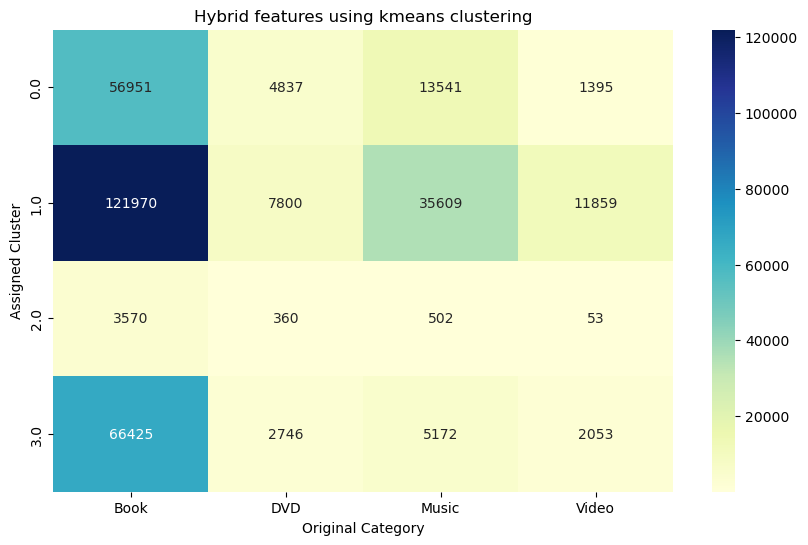

In [35]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.title('Hybrid features using '+ config.CLUSTERING_ALGORITHM + ' clustering' )
plt.xlabel('Original Category')
plt.ylabel('Assigned Cluster')
plt.show()

## Phase 3 : Calculating NMI

In [36]:
df_eval_hybrid = df_final.dropna(subset=['group', 'cluster_hybrid'])

nmi_hybrid = normalized_mutual_info_score(df_eval_hybrid['group'], df_eval_hybrid['cluster_hybrid'])

print(f"Normalized Mutual Information (NMI): {nmi_hybrid:.4f}")

log_clustering_results("Hybrid", nmi_hybrid, overwrite=False)

Normalized Mutual Information (NMI): 0.0226
Clustering results for Hybrid saved correctly.


---
---
# Results

### Original Categories Plotting

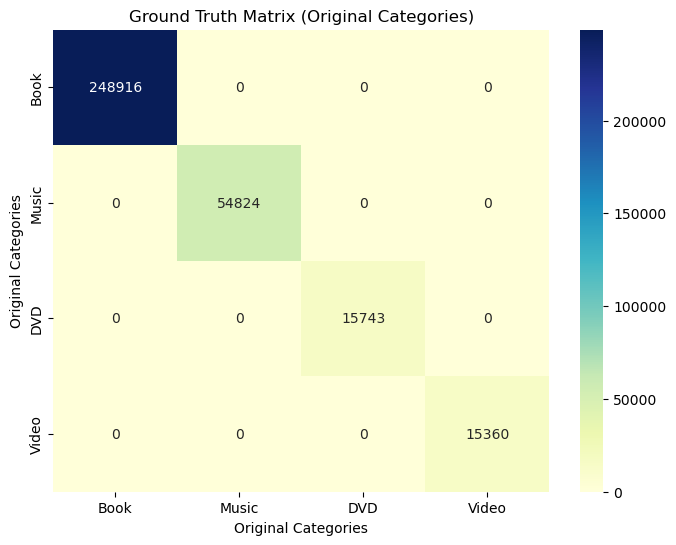

In [37]:
# Original clustering
# Print the original clustering figure

# Extract ground truth groups from the graph
groups_dict = nx.get_node_attributes(G, 'group')
groups_series = pd.Series(groups_dict)

# Count occurrences of each category
counts = groups_series.value_counts()
categories = counts.index.tolist()

# Make an empty confusion matrix
gt_matrix = pd.DataFrame(0, index=categories, columns=categories)

# Fill the diagonal with the real counts
for cat in categories:
    gt_matrix.loc[cat, cat] = counts[cat]

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(gt_matrix, annot=True, fmt='d', cmap='YlGnBu')

plt.title('Ground Truth Matrix (Original Categories)')
plt.xlabel('Original Categories')
plt.ylabel('Original Categories')
plt.show()

SUMMARY:


,NMI
method,
Structural,0.0226
Learned,0.1693
Hybrid,0.0226


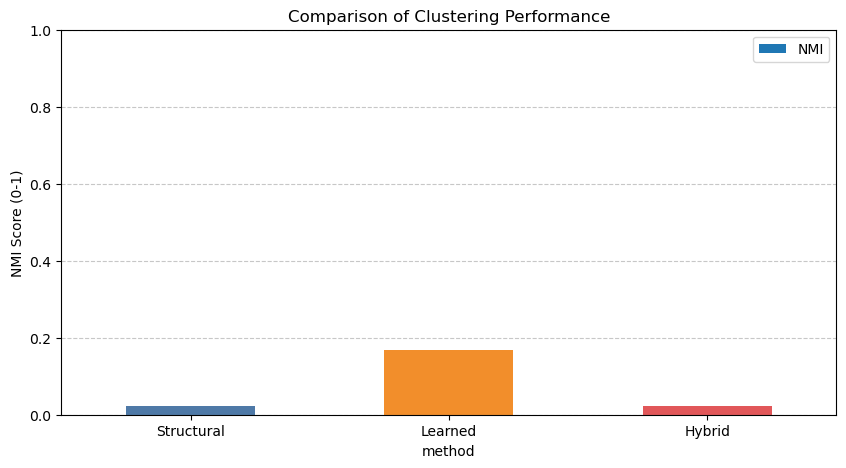

In [38]:
# Upload results
df_results = pd.read_csv(RESULTS_FILE)

# Group them by
summary = df_results.groupby('method')[['NMI']].first()
order = ['Structural', 'Learned', 'Hybrid']
summary = summary.reindex(order).dropna()

# Print table for comparisons
print("SUMMARY:")
display(summary)

# Plot
summary.plot(kind='bar', figsize=(10, 5))
summary['NMI'].plot(kind='bar', color=['#4e79a7', '#f28e2b', '#e15759'])

plt.ylim(0, 1.0)
plt.title("Comparison of Clustering Performance")
plt.ylabel("NMI Score (0-1)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()